In [50]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os

import IPython.display as ipd

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support,f1_score,fbeta_score
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

import librosa
import librosa.display
import ast

import keras
plt.rcParams['figure.figsize'] = (17, 5)



In [51]:
df = pd.read_csv('data.csv')

In [52]:
df.head()

,filename,chroma_cqt,chroma_cens,chroma_stft,spectral_centroid,spectral_bandwidth,spectral_contrast,rolloff,zero_crossing_rate,tonnetz,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
0,126014,0.267008,0.171130,0.237383,699.229710,785.999971,25.676751,1183.751175,0.041712,0.092841,...,-27.326481,-20.607473,-12.659972,-13.275584,-12.988043,-15.687397,-12.339302,2.211766,2.147864,-5.011512
1,54496,0.274600,0.207362,0.277710,1833.074733,2091.124342,25.274995,3818.560243,0.093890,0.044640,...,-5.424025,6.843907,-6.247772,3.441898,-0.244973,4.090439,-1.278771,9.071951,-0.169724,0.161876
2,65893,0.458305,0.253559,0.412075,2767.487106,2741.112704,20.450162,5889.689386,0.111506,0.013648,...,-8.586940,6.649025,-2.908488,3.085722,-3.682684,2.957125,-2.243021,1.578797,-4.537785,1.052801
3,71158,0.531325,0.258276,0.424391,1444.225428,2060.084462,19.861984,3089.631317,0.046734,0.000029,...,5.303405,-0.030636,-1.089045,2.822888,-2.630777,1.943587,-7.131413,1.516889,-0.094114,-0.776687
4,57821,0.412456,0.239312,0.335196,2253.305912,2412.719760,22.327731,4858.028957,0.099870,0.024816,...,-8.056653,-5.495337,-8.891809,-2.783748,-6.777088,-3.736772,-11.871335,-0.826213,-2.934075,6.011378


In [53]:
df.shape

(7997, 30)

In [54]:
genres = pd.read_csv('data/fma_metadata/genrelist.csv')

In [55]:
genres

,Unnamed: 0,genre,testtrainval
0,NaN,NaN,NaN
1,track_id,NaN,NaN
2,2,Hip-Hop,training
3,5,Hip-Hop,training
4,10,Pop,training
...,...,...,...
7997,154308,Hip-Hop,test
7998,154309,Hip-Hop,test
7999,154413,Pop,training
8000,154414,Pop,training


In [56]:
genres.rename({'Unnamed: 0':'track_id'},axis=1,inplace=True)

In [57]:
genres = genres.drop(index=[0,1])

In [58]:
genres.head()

,track_id,genre,testtrainval
2,2,Hip-Hop,training
3,5,Hip-Hop,training
4,10,Pop,training
5,140,Folk,training
6,141,Folk,training


In [59]:
genres['track_id'] = genres['track_id'].astype('int64')

In [60]:
df.rename({'filename':'track_id'},axis=1,inplace=True)

In [61]:
df['track_id']

0       126014
1        54496
2        65893
3        71158
4        57821
         ...  
7992     43695
7993     68410
7994     51291
7995     96902
7996     75441
Name: track_id, Length: 7997, dtype: int64

In [62]:
data=pd.merge(df,genres,on='track_id')

In [63]:
data['genre']

0        Instrumental
1        Experimental
2                Folk
3             Hip-Hop
4             Hip-Hop
            ...      
7992    International
7993     Experimental
7994              Pop
7995     Experimental
7996     Instrumental
Name: genre, Length: 7997, dtype: object

In [64]:
data.set_index('track_id',inplace=True)

In [65]:
data.head()

,chroma_cqt,chroma_cens,chroma_stft,spectral_centroid,spectral_bandwidth,spectral_contrast,rolloff,zero_crossing_rate,tonnetz,mfcc1,...,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,genre,testtrainval
track_id,,,,,,,,,,,,,,,,,,,,,
126014,0.267008,0.171130,0.237383,699.229710,785.999971,25.676751,1183.751175,0.041712,0.092841,-352.161438,...,-12.659972,-13.275584,-12.988043,-15.687397,-12.339302,2.211766,2.147864,-5.011512,Instrumental,training
54496,0.274600,0.207362,0.277710,1833.074733,2091.124342,25.274995,3818.560243,0.093890,0.044640,-290.169464,...,-6.247772,3.441898,-0.244973,4.090439,-1.278771,9.071951,-0.169724,0.161876,Experimental,training
65893,0.458305,0.253559,0.412075,2767.487106,2741.112704,20.450162,5889.689386,0.111506,0.013648,-80.027184,...,-2.908488,3.085722,-3.682684,2.957125,-2.243021,1.578797,-4.537785,1.052801,Folk,training
71158,0.531325,0.258276,0.424391,1444.225428,2060.084462,19.861984,3089.631317,0.046734,0.000029,-123.564980,...,-1.089045,2.822888,-2.630777,1.943587,-7.131413,1.516889,-0.094114,-0.776687,Hip-Hop,training
57821,0.412456,0.239312,0.335196,2253.305912,2412.719760,22.327731,4858.028957,0.099870,0.024816,-71.340874,...,-8.891809,-2.783748,-6.777088,-3.736772,-11.871335,-0.826213,-2.934075,6.011378,Hip-Hop,training


In [66]:
data['testtrainval'].value_counts()

training      6397
validation     800
test           800
Name: testtrainval, dtype: int64

In [67]:
y = data[['genre','testtrainval']]

In [68]:
y.drop('testtrainval',axis=1,inplace=True)

In [69]:
X = data.drop(['genre','testtrainval'],axis=1)

In [70]:
X_train, X_test, y_train , y_test = train_test_split(X,y,stratify=y,test_size=0.15)

In [71]:
X_train.shape,X_test.shape

((6797, 29), (1200, 29))

In [72]:
X_train

,chroma_cqt,chroma_cens,chroma_stft,spectral_centroid,spectral_bandwidth,spectral_contrast,rolloff,zero_crossing_rate,tonnetz,mfcc1,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
track_id,,,,,,,,,,,,,,,,,,,,,
134586,0.279802,0.174576,0.219053,711.612335,791.486536,23.956059,1079.110141,0.042508,0.062160,-265.221985,...,-31.777815,-28.431187,-14.370870,0.836271,2.875372,1.080896,3.977772,-0.804846,-8.402043,-1.118009
45516,0.477362,0.242334,0.373809,2223.311713,2807.772344,22.889447,5472.575241,0.100494,0.016019,-149.956024,...,-15.779222,-2.650319,-16.850363,2.082205,-15.376483,0.549566,-14.019407,-0.612120,-13.714358,0.204706
11268,0.573520,0.267717,0.323504,2549.524378,2440.293622,20.126391,5139.960586,0.125582,-0.001616,-102.165115,...,-1.847047,-0.525816,-1.025268,8.194746,-3.367933,-2.454880,-1.489127,6.383095,-2.280081,-2.442429
74376,0.293708,0.192713,0.265614,1519.317371,1961.931147,24.684805,2827.999566,0.064981,0.081155,-192.114380,...,-19.275587,-5.527548,-15.367741,-0.516155,-12.131804,1.925415,-2.049032,0.596097,-9.524216,0.308405
10485,0.342175,0.210889,0.353428,1887.438042,1798.760659,23.088791,3511.087102,0.114982,0.114209,-47.722286,...,-11.142817,4.868912,-9.212234,0.176968,-6.321789,3.152178,-2.849862,0.250349,-1.814833,6.190097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9721,0.651030,0.280872,0.594901,3462.814895,3001.608354,16.892738,7394.130289,0.220129,0.009573,151.637939,...,-0.625359,7.165051,-0.883904,5.781523,-5.066007,-0.335541,-4.615020,3.041496,-2.312097,2.986805
111335,0.492070,0.260241,0.482968,2253.127572,2381.882074,19.343523,4716.129816,0.102382,0.029615,-4.581572,...,-10.746713,4.242385,-4.828452,0.010337,-8.050809,-6.034163,-6.484439,1.615790,-4.528823,2.320088
107388,0.297959,0.210212,0.333333,2112.496666,2128.618986,23.013093,4101.141868,0.104937,0.116035,-55.743534,...,-7.271213,0.162537,-6.247407,-8.029799,-10.766673,-2.460017,-10.205006,-6.645385,-3.391064,1.799339


In [73]:
1200/6397

0.18758793184305142

In [74]:
encoder = LabelEncoder()

In [75]:
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)


In [76]:
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=42)

In [77]:
classifier.score(X_train,y_train)

0.9879358540532588

In [78]:
classifier.score(X_test,y_test)

0.425

In [79]:
rf_pipeline = Pipeline([('ss', StandardScaler()),('RF',RandomForestClassifier())])

In [80]:
rf_pipeline.fit(X_train,y_train)

Pipeline(steps=[('ss', StandardScaler()), ('RF', RandomForestClassifier())])

In [83]:
rf_pipeline.score(X_train,y_train)

0.9998528762689421

In [51]:
params = [{'RF__max_depth': [4, 5, 6], 'RF__criterion':['gini','entropy'],
           'RF__max_features' :['auto', 'sqrt'],
         'RF__min_samples_split': [2, 5, 10], 
           'RF__n_estimators':[5,10,50,100,250,500],
         'RF__min_samples_leaf': [1, 2, 4]}]

In [52]:
rf_cv = GridSearchCV(estimator=rf_pipeline,param_grid=params,cv=5)

In [53]:
rf_cv.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('RF', RandomForestClassifier())]),
             param_grid=[{'RF__criterion': ['gini', 'entropy'],
                          'RF__max_depth': [4, 5, 6],
                          'RF__max_features': ['auto', 'sqrt'],
                          'RF__min_samples_leaf': [1, 2, 4],
                          'RF__min_samples_split': [2, 5, 10],
                          'RF__n_estimators': [5, 10, 50, 100, 250, 500]}])

In [54]:
rf_best = rf_cv.best_estimator_
rf_cv.best_params_

{'RF__criterion': 'gini',
 'RF__max_depth': 6,
 'RF__max_features': 'auto',
 'RF__min_samples_leaf': 4,
 'RF__min_samples_split': 5,
 'RF__n_estimators': 250}

In [55]:
rf_best.score(X_train,y_train),rf_best.score(X_test,y_test)

(0.5099587295890903, 0.3975)

In [56]:
rf_best.score(X_val,y_val)

0.41748366013071897

In [33]:
import xgboost as xgb


In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score

from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression 


def plot_confusion_matrix(y_test,y_test_preds,data='test'):
    cm_test = confusion_matrix(y_test,y_test_preds)
    print(f"{cm_test[1][0]/cm_test.sum()*100} of False Negatives")
    sns.heatmap(cm_test,cmap=sns.color_palette('Blues'),fmt ='.1f',annot=True)
    plt.ylim([2,0])
    plt.title(f"Confusion Matrix\n{data} Data")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))
    

def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')



In [35]:

def plot_cm(y_true, y_pred, figsize=(10,10)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_train).astype(int))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = f'{p:.1f}'#'%.1f%%\n%d/%d' % (p, c, s)
            elif p < 10.:
                annot[i, j] = ''
            else:
                annot[i, j] = f'{p:.1f}'#'%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_train).astype(int), columns=np.unique(y_train))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "Blues", annot=annot, fmt='', ax=ax)
    plt.ylim([8,0])



In [36]:
plot_cm(y_train,xgb_best.predict(X_train))

NameError: name 'xgb_best' is not defined

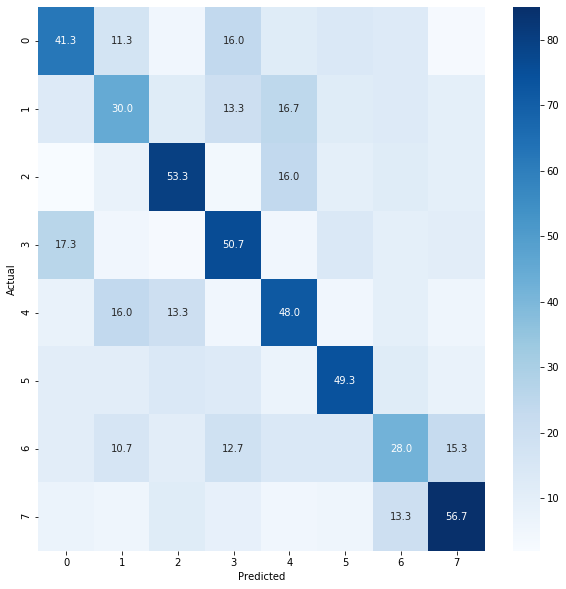

In [74]:
plot_cm(y_test,xgb_best.predict(X_test))

In [76]:
d = pd.DataFrame(xgb_best.predict(X_test))

In [78]:
d['act'] = y_test

In [79]:
d.head()

,0,act
0,4,4
1,6,0
2,7,3
3,6,6
4,3,0


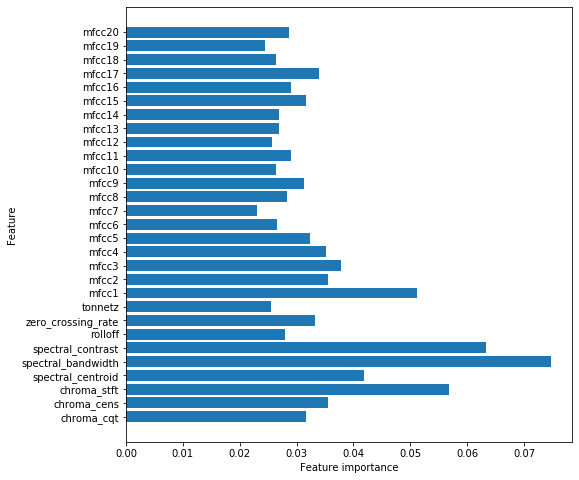

In [82]:
plot_feature_importances(xgb_best[1])

In [84]:
classifier = xgb.XGBClassifier()
classifier.fit(X_train, y_train)

XGBClassifier(objective='multi:softprob')

In [85]:
classifier.score(X_train,y_train),classifier.score(X_test,y_test)

(0.5809916139473297, 0.4708333333333333)

In [40]:
preds = classifier.predict(X_test)

In [41]:
preds

array([3, 1, 4, ..., 7, 5, 7])

In [43]:
y_test

array([0, 0, 7, ..., 4, 6, 7])

In [86]:
xgb_pipeline = Pipeline([('ss',StandardScaler()),('xgb',xgb.XGBClassifier())])


In [87]:
xgb_pipeline.fit(X_train,y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('xgb', XGBClassifier(objective='multi:softprob'))])

In [89]:
xgb_pipeline.score(X_train,y_train)

0.5809916139473297

In [90]:
xgb_pipeline.score(X_test,y_test)

0.4708333333333333

In [42]:
params = {
    "xgb__learning_rate": [0.001,0.05,0.01,0.1,0.5],
    'xgb__max_depth': [3,5,7],
    'xgb__subsample': [1],
    'xgb__n_estimators': [5, 50, 100, 250,500,750],
}

In [43]:
xgb_cv = GridSearchCV(estimator =xgb_pipeline,param_grid=params,n_jobs=-1,cv=5)

In [44]:
xgb_cv.fit(X_train,y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('xgb',
                                        XGBClassifier(num_class=8,
                                                      objective='multi:softprob'))]),
             n_jobs=-1,
             param_grid={'xgb__learning_rate': [0.001, 0.05, 0.01, 0.1, 0.5],
                         'xgb__max_depth': [3, 5, 7],
                         'xgb__n_estimators': [5, 50, 100, 250, 500, 750],
                         'xgb__subsample': [1]})

In [45]:
xgb_best = xgb_cv.best_estimator_
xgb_cv.best_params_

{'xgb__learning_rate': 0.1,
 'xgb__max_depth': 7,
 'xgb__n_estimators': 750,
 'xgb__subsample': 1}

In [46]:
xgb_best.score(X_train,y_train)

0.9998205634308271

In [47]:
xgb_best.score(X_test,y_test)

0.44666666666666666

In [48]:
xgb_best.score(X_val,y_val)

0.49264705882352944

In [59]:
xgb_preds = xgb_best.predict(X_test)

0.0 of False Negatives


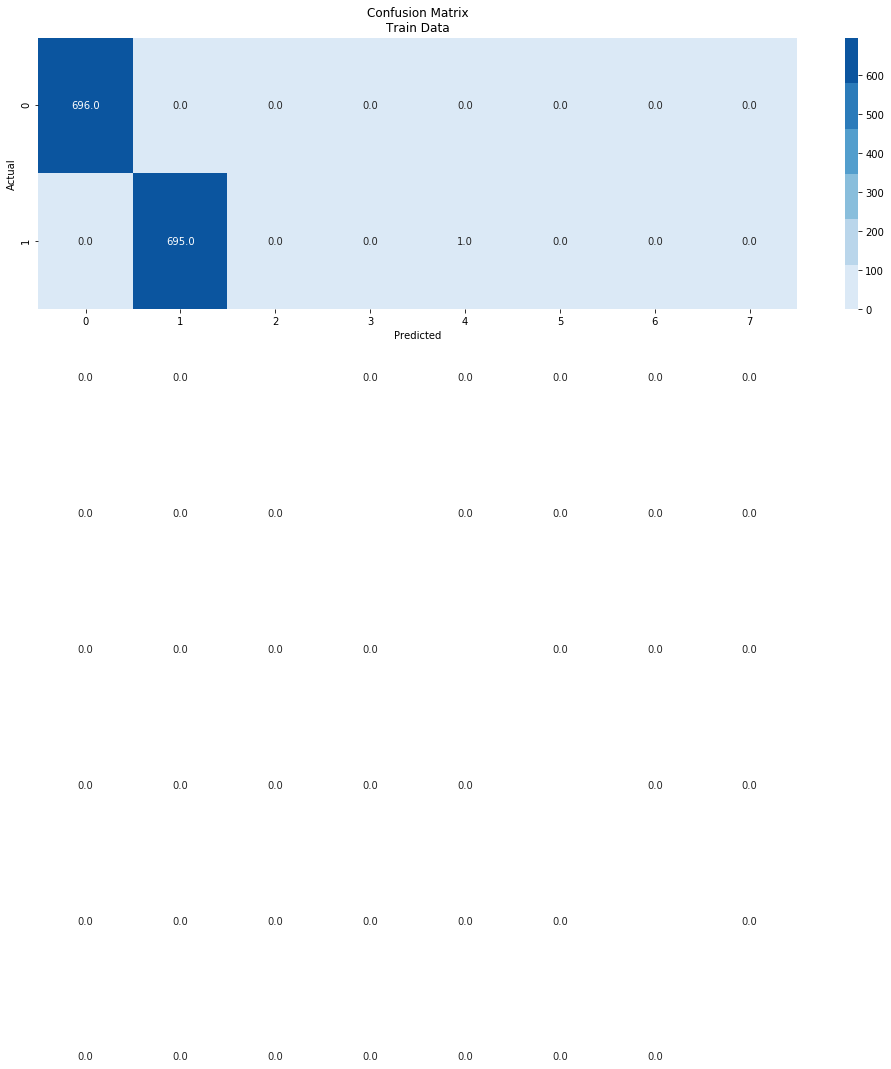

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [62]:
plot_confusion_matrix(y_train,xgb_best.predict(X_train),data='Train')
print_metrics(y_train,xgb_best.predict(X_train))